Importamos la biblioteca Gymnassium, que vamos a usar como framework de RL

In [2]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

Creamos un ambiente y lo mostramos en pantalla. Para esto definimos una función para imprimir nuestro ambiente.

In [3]:
# La semilla usada para crear el ambiente
semilla = 1

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(estado):
  env_str = estado.render()
  print(env_str)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+





El rectángulo de color representa el taxi, amarillo cuando va sin pasajero y verde con pasajero.
'|' representa una pared que el taxi no puede cruzar, es decir.
R, G, Y, B son los puntos de interés, es decir, las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Si cambiamos la semilla, cambia el estado del ambiente.

In [4]:
# Una semilla diferente
semilla = 2

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Exploremos el espacio de estados y de acciones:

In [5]:
print(f"Espacio de Acciones {entorno.action_space}")
print(f"Espacio de Estados {entorno.observation_space}")

Espacio de Acciones Discrete(6)
Espacio de Estados Discrete(500)


Hay 6 acciones, que corresponden a:
 * 0 = ir al Sur
 * 1 = ir al Norte
 * 2 = ir al Este
 * 3 = ir al Oeste
 * 4 = recoger pasajero
 * 5 = dejar pasajero

Los puntos cardinales siguen la convención Norte hacie arriba. Recoger/dejar al pasajero solo tienen efecto si el taxi está en la misma casilla que el pasajero, y en uno de los puntos de interés.

Nuestro agente deberá elegir la acción a tomar en cada paso. Gymnassium nos expone funciones para esto. Si queremos movernos al sur, por ejemplo:

In [6]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

accion = 0 # Sur
entorno.step(accion)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



Ahora estamos listos para programar un agente. Empezando por uno random. Se puede ejecutar el codigo abajo varias veces para ver como cambia en cada ejecución, debido a que la semilla_acciones es diferente.

In [7]:
import random 

def episodio_random(semilla_ambiente = 2):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env
    entorno.reset(seed = semilla_ambiente)

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # para la animación

    termino = False
    truncado = False

    while not termino and not truncado:
        #  selecciona una acción aleatoria del conjunto de todas las posibles acciones
        accion = entorno.action_space.sample() 
        estado, recompensa, termino, truncado, info = entorno.step(accion)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        iteraciones += 1


    print("Iteraciones: ",iteraciones)
    print("Penalizaciones: ", penalizaciones)

    return marcos

marcos = episodio_random()

Iteraciones:  69
Penalizaciones:  16


Podemos ver el episodio completo abajo. Notar que seleccionamos la semillia de selector de acciones para que la corrida sea 'buena'.

In [8]:
from IPython.display import clear_output
from time import sleep
import sys

def print_frames(marcos):
    for i, marco in enumerate(marcos):
        clear_output()
        print(marco['marco'])
        print(f"Iteracion: {i + 1}")
        print(f"Estado: {marco['estado']}")
        print(f"Accion: {marco['accion']}")
        print(f"Recompensa: {marco['recompensa']}")
        sys.stdout.flush()
        # Aumentar este tiempo para ver mejor la animación
        sleep(.01)

print_frames(marcos)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 69
Estado: 0
Accion: 5
Recompensa: 20


Ahora queremos programar un agente inteligente, para eso nos vamos a atener a la siguiente interfaz.

In [9]:
class Agente:
    def elegir_accion(self, estado, max_accion) -> int: 
        """Elegir la accion a tomar en el estado actual y el espacio de acciones"""
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa): 
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
        """
        pass

Para nuestro agente aleatorio, esto sería:

In [10]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # No aprende
        pass

Poniendolo a jugar:

In [11]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env

agente = AgenteAleatorio()

iteraciones = 0
penalizaciones, recompensa = 0, 0

marcos = [] # for animation

termino = False
truncado = False
estado_anterior, info = entorno.reset(seed = semilla)
while not termino and not truncado:
    # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
    accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
    # Realizamos la accion
    estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
    # Le informamos al agente para que aprenda
    agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

    # El agente trato de dejar/recoger al pasajero incorrectamente
    if recompensa == -10:
        penalizaciones += 1

    # Put each rendered frame into dict for animation
    marcos.append({
        'marco': entorno.render(),
        'estado': estado_siguiente,
        'accion': accion,
        'recompensa': recompensa
        }
    )

    estado_anterior = estado_siguiente
    iteraciones += 1


print(f"Iteraciones: {iteraciones}")
print(f"Penalizaciones: {penalizaciones}")

Iteraciones: 421
Penalizaciones: 149


Podemos encapsular lo anterior en una función 

In [12]:
def ejecutar_episodio(agente, semilla):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # for animation

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        estado_anterior = estado_siguiente
        iteraciones += 1
    return iteraciones, penalizaciones, marcos


y correrlo varias veces para ver el rendimiento promedio

In [13]:
agente = AgenteAleatorio()
semilla = 1
num_iteraciones_episodios = []
num_penalizaciones_episodios = []
for i in range(10):
    num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    num_penalizaciones_episodios += [penalizaciones]

Y obtener métricas al respecto

In [14]:
import numpy
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)} iteraciones en promedio")
print(f"Con {numpy.mean(num_penalizaciones_episodios)} penalizaciones promedio")

#print_frames(marcos)

Se realizaron 2213.1 iteraciones en promedio
Con 712.7 penalizaciones promedio


## La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

El objetivo de esta tarea consiste en programar un agente que logre aprender mediante aprendizajes por refuerzos utilizando un algoritmo de Q learning. En la narrativa del problema puntual tenemos un taxi que se encuentra en un mapa definido donde su objetivo es levantar a un pasajero de una cierta ubicación y dejarlo en otra.

Para esto implementaremos la clase AgenteRL con las funciones que le permiten al agente navegar el entorno tomando decisiones de hacia donde dirigirse con tal de llegar al objetivo. Almacenaremos la información de las trancisiones del entorno en la tabla Q y en base a ella, eligiendo la mejor acción para un cierto estado con probabilidad 1-$\epsilon$ y una acción cualquiera con probabilidad $\epsilon$. Tendremos la función aprender que permitirá al Taxi actualizar esa tabla Q a medida que recorra el ambiente y reciba las recomensas.

Evaluaremos el desempeño del agente en base a la cantidad de iteraciones que le lleve dejar al pasajero en su lugar y además viendo las penalizaciones que recibe en el camino (cada vez que deja o recoje al pasajero en un lugar incorrecto). También visualizaremos la tabla Q para entender que cosas logra registrar el agente después de varias iteraciones de entrenamiento.

In [15]:
#!pip install matplotlib
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [16]:
class AgenteRL(Agente):
    def __init__(self, entorno, alpha=0.1, gamma=0.9, epsilon=0.1, inicio = "azar") -> None:
        super().__init__()
        self.entorno = entorno
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Probabilidad de exploración

        # Inicializa la tabla Q con valores aleatorios
        self.num_acciones = entorno.action_space.n
        self.num_estados = entorno.observation_space.n
        if inicio == "azar": # Posibilidad de iniciar tabla Q en 0 o al azar
            self.Q = np.random.uniform(low=-1, high=1, size=(self.num_estados, self.num_acciones))
        else:
            self.Q = np.zeros((self.num_estados,self.num_acciones))


    def elegir_accion(self, estado, max_accion) -> int:
        # Selección de acción epsilon-greedy
        if random.uniform(0, 1) < self.epsilon:
            return self.entorno.action_space.sample()  # Acción aleatoria
        else:
            return np.argmax(self.Q[estado, :])  # Acción con el valor máximo de Q

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # Actualiza la tabla Q usando la regla de Q-Learning
        valor_actual = self.Q[estado_anterior, accion]
        max_valor_siguiente = np.max(self.Q[estado_siguiente, :])
        nuevo_valor = (1 - self.alpha) * valor_actual + self.alpha * (recompensa + self.gamma * max_valor_siguiente)
        self.Q[estado_anterior, accion] = nuevo_valor

In [17]:
def Evolucion(agente, iteraciones, semilla, reproducir = False):
    """ Toma un agente y evalúa su evolución en la cantidad de iteraciones indicadas en el contexto de un ambiente definido por la semilla indicada, si llamamos con reproducir = True nos reproduce el episodio entero. Si definimos la semilla como "all" entonces veremos la evolución cuando en cada iteración tomamos una semilla nueva"""
    num_iteraciones_episodios = []
    num_penalizaciones_episodios = []

    if semilla == "all": # incluimos la posibilidad ver la evolución del agente si lo entrenamos cambiando en cada iteración el entorno
        for i in range(iteraciones):
            num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente, semilla=i)
            num_iteraciones_episodios += [num_iteraciones]
            num_penalizaciones_episodios += [penalizaciones]
            if reproducir:
                print_frames(marcos)

    else:
        for i in range(iteraciones):
            num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente, semilla)
            num_iteraciones_episodios += [num_iteraciones]
            num_penalizaciones_episodios += [penalizaciones]
            if reproducir:
                print_frames(marcos)

    promedio_iteraciones = np.mean(num_iteraciones_episodios)
    promedio_penalizaciones = np.mean(num_penalizaciones_episodios)
    print(f"Se realizaron {promedio_iteraciones} en promedio.")
    print(f"con {promedio_penalizaciones} penalizaciones en promedio.")

    plt.figure(figsize=(8, 4))

    plt.subplot(1,2,1)
    plt.plot(num_iteraciones_episodios)
    plt.title("Iteraciones")

    plt.subplot(1,2,2)
    plt.plot(num_penalizaciones_episodios, color = "red")
    plt.title("Penalizaciones")

    plt.suptitle("Evolución hasta dejar el pasajero")



In [18]:
def split_matrix(matrix, num_splits):
    '''Parte la matriz en num_splits tramos verticales'''
    # Calculate the number of rows in each submatrix
    num_rows = len(matrix) // num_splits

    # Create a list to store the submatrices as DataFrames
    submatrices = []

    # Split the long matrix into submatrices
    for i in range(num_splits):
        start_row = i * num_rows
        end_row = start_row + num_rows
        submatrix_data = matrix[start_row:end_row, :]
        submatrix_df = pd.DataFrame(submatrix_data, columns=['Sur', 'Norte', 'Este', 'Oeste', 'Recoger', 'Dejar']) 
        submatrix_df.index = range(start_row, end_row)
        submatrices.append(submatrix_df)
    return submatrices


In [19]:
def grilla_plot(submatrices, num_rows , num_cols, colormap = 'viridis',titulo = ""):
    '''Genera un heatmap en grilla con num_rows y num_cols'''
    if len(submatrices) <= num_rows * num_cols:
        # Assuming 'submatrices' is a list of DataFrames
        num_plots = len(submatrices)

        # Define the layout of subplots (3 rows and 2 columns)
        num_rows = 3
        num_cols = 2

        # Calculate the total number of subplots required
        num_subplots = num_rows * num_cols
        
        # Create a figure with the specified number of subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8),sharex=True)

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        #Normalice the color scale
        norm = plt.Normalize(-15,15)

        # Loop through the submatrices and plot them
        for i, submatrix in enumerate(submatrices):
            if i < num_subplots:
                ax = axes[i]
                sns.heatmap(submatrix, cmap=colormap, ax=ax,norm = norm, cbar=False, linewidths=0.4)
                ax.set_title(f'Heatmap {i + 1}')

        # Hide any remaining empty subplots
        for i in range(num_subplots, num_plots):
            axes[i].axis('off')

        # Create a unique colorbar outside of the subplots
        cbar = fig.colorbar(axes[0].collections[0], ax=axes, pad=0.05)
        cbar.set_label('Colorbar Label')

        # Adjust spacing between subplots
        #plt.tight_layout()

        # Show the plot
        plt.suptitle(titulo,fontsize = 20)
        plt.show()

### Ejecutamos muchos episodios con la misma semilla:

Entorno de semilla 1

In [20]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Se realizaron 25.53 en promedio.
con 1.042 penalizaciones en promedio.


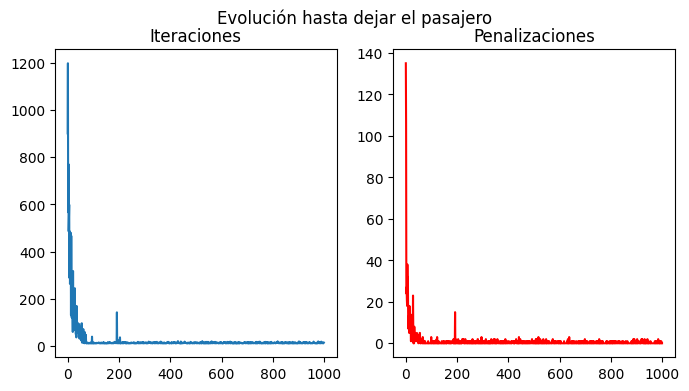

In [21]:
agente1 = AgenteRL(entorno, inicio = "zero")
Evolucion(agente1,1000,semilla=1)

Se observa claramente que durante las primeras iteraciones el taxi tiene serios problemas para resolver la tarea, y esto se debe a que comienza sin información sobre el entorno y lo mejor que puede hacer es tomar decisiones al azar y ver cómo el ambiente lo recompenza. Rápidamente la tabla Q se actualiza indicandole al agente información sobre su entorno y esto lleva a una rápida mejoría, luego de las primeras 100 ejecuciones pasa a tener un rendimiento estable sobre la semilla que estaba entrenando. 

En algunas corridas ocurre que en un determinado momento se observa un crecimiento fuera de lo común en la cantidad de iteraciones y penalizaciones, no tenemos una explicación para este fenomeno pero identificamos que no es un problema para el desempeño global ya que observamos que es un evento muy raro. 

### Visualizamos la tabla Q.
Por haber tantos estados posibles y solo 5 acciones que el agente puede realizar obtenemos que la tabla Q es muy larga y angosta, por ello la partimos en 6 tramos para poder visualizarla mejor. Generamos un heatmap que nos permite ver el tipo de cosas que el agente reconoce.

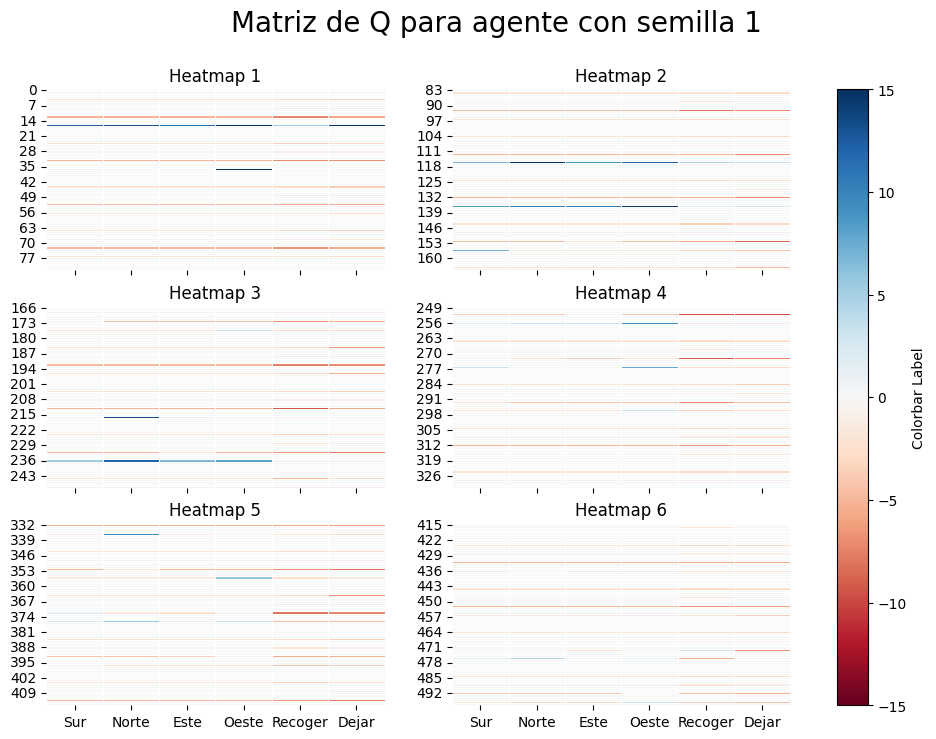

In [22]:
submatrices1 = split_matrix(agente1.Q, 6)
grilla_plot(submatrices1, 2 , 3, colormap = plt.cm.RdBu, titulo = "Matriz de Q para agente con semilla 1")

Identificamos que tenemos un estado con valores altos de todas las acciones, probablemente este estado sea el de llegada. También se visualiza como por cada acción hay uno o dos estados en los que es más conveniente realizar esa acción en concreto.

La tabla Q en este caso de entrenamiento se inicializó en todo en 0. Por lo tanto todos los valores blancos del gráfico es posible que no hayan sido visitados.

Es interesante observar como no las acciones Norte y oeste son las que tienen más cantidad de entradas muy positivas, esto es posible que se deba a que el lugar de dejar al pasajero es en una esquina arriba a la izquierda. Por lo tanto nunca llegamos a este estado tomando una decisión Sur o Este.

También se visualiza en la matriz que no hay grandes valores para la acción recoger, esto es probable que esté asociado a que el ambiente no recompensa especialmente el momento de levantar al pasajero, aunque sí el de dejarlo y para ello es necesario haberlo levantado antes.

#### Hacemos la corrida cambiando la semilla del ambiente con el agente que ya entrenamos

A continuación cambiamos la semilla del ambiente y ponemos el agente entrenado a la semilla 1 a realizar la tarea en un ambiente desconocido.

Entotno de semilla 2

In [23]:
semilla = 2
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Se realizaron 60.52 en promedio.
con 2.86 penalizaciones en promedio.


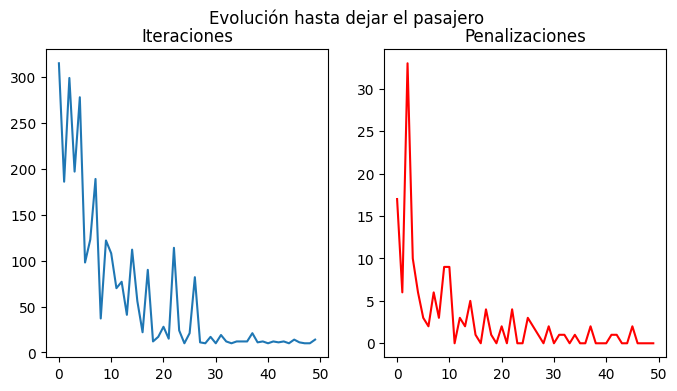

In [24]:
Evolucion(agente1, 50, semilla = 2)

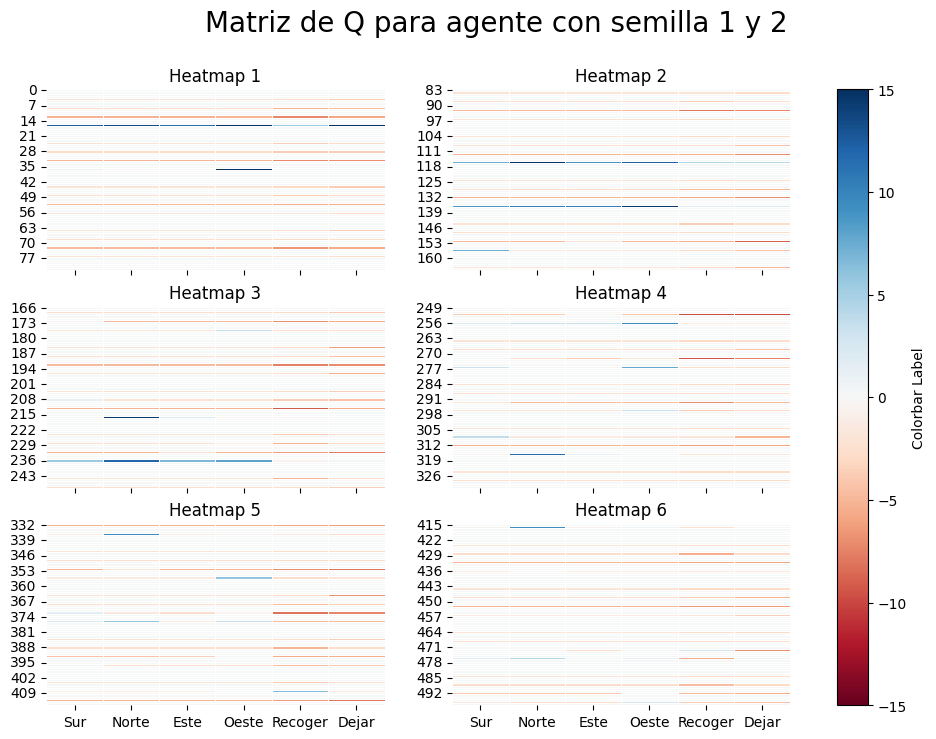

In [25]:
submatrices1 = split_matrix(agente1.Q, 6)
grilla_plot(submatrices1, 2 , 3, colormap = plt.cm.RdBu, titulo = "Matriz de Q para agente con semilla 1 y 2")

Observamos que al correr en un ambiente de semilla 2 pero habiendo sido entrenado con la semilla 1 tenemos un mal desempeño al comienzo pero con las iteraciones el rendimiento va mejorando hasta lograr una gran consistencia en las ultimas 10 iteraciones. Elegimos solo 50 iteraciones para observar mejor el rendimiento al comenzar la tarea.

Otra cosa que nos saltó a la vista es que los ambientes de semilla 1 y 2 son bastante similares, ya que comparten el lugar donde dejar al pasajero, esto genera que con unas pocas iteraciones el taxi logre un bastante buen desempeño. Esto también aparece reflejado en la tabla Q donde vemos que si bien aparecen más entradas pintadas que en la matriz anterior aún quedan muchas entradas en blanco y en particular mirando en la columna de Dejar no tenemos nuevas entradas positivas, que devuelta se corresponde con el hecho de que ambos entornos tienen la llegada en un mismo lugar.

Suponemos que en un entorno en el que el agente no tenga entrenado el lugar de llegada vamos a observar peores resultados. Probaremos con el ambiente de semilla 6, que no comparte lugar de salida ni de llegada.

In [26]:
semilla = 6
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Se realizaron 79.73 en promedio.
con 4.89 penalizaciones en promedio.


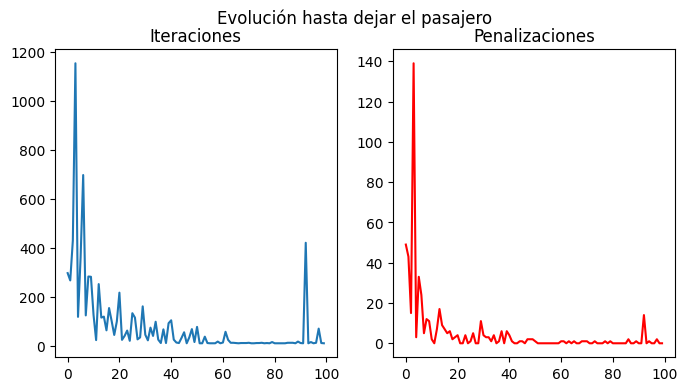

In [27]:
Evolucion(agente1, 100, semilla = 6)

En el ambiente de semilla 6 tenemos algo distinto a lo que el agente había entrenado y esto se refleja en la diferencia que hay entre esta evolucion y el que tenemos en semilla 2. Incluso necesitamos algunas iteraciones más para lograr un rendimiento estable.

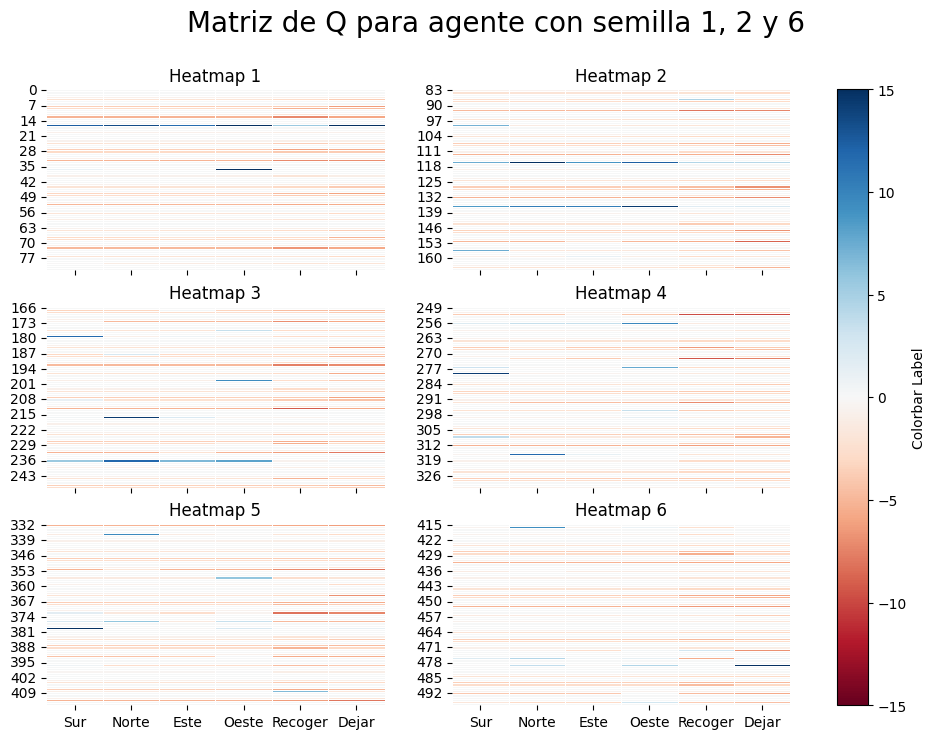

In [28]:
submatrices1 = split_matrix(agente1.Q, 6)
grilla_plot(submatrices1, 2 , 3, colormap = plt.cm.RdBu, titulo = "Matriz de Q para agente con semilla 1, 2 y 6")

Observando la matriz Q del agente luego de haber recorrido por los espacios de semillas 1, 2 y 6 vemos que a medida que pasan los nuevos ambientes el agente incorporpora nociones nuevas, la matriz aparece un poco menos blanca, lo cual indica que está recorriendo una variedad más amplia de estados. Si miramos la columna que corresponde a las accion Dejar vemos que luego de los dos primeros ambientes solo había una fila que tenía valores muy positivos (porque el punto de dejar al pasajero en ambos casos era igual), cuando aparece el entorno de semilla 6 vemos que aparece una nueva barrita en esta columna y esto se debe a que el punto de finalización del pasajero con esta semilla es nuevo, por lo tanto el agente incorpora esta nueva posibilidad.

### Posibles mejoras para semilla aleatoria

Observando los resultados anteriores vemos que el agente responde bien a los entornos que conoce. Cuando aparece un entorno que no había visto le lleva algunas iteraciones ajustar la tabla Q para lograr el objetivo. Un punto interesante es lo que ocurre cuando entrenamos con la semilla 1 y luego vemos la evolución utilizando un ambiente de semilla 2. Es cierto que tiene un mal comienzo pero logra aprender el espacio, y lo logra más rápidamente que cuando lo ponemos en el entorno de semilla 6. En este último vemos que tiene dificultades mayores para adaptarse. Podemos concluir que cuanto más similar sea el entorno a uno en el que el agente ya entrenó, más fácil se adpta a él. 

Por lo tanto pensando en implementar un agente que se desempeñe bien en cualquier semilla nos interesaría entrenar al agente en entornos variados. En lugar de entrenar 1000 iteraciones en el entorno 1 podríamos intentar entrenar con las primeras 1000 semillas.

Se realizaron 92.48 en promedio.
con 4.517 penalizaciones en promedio.


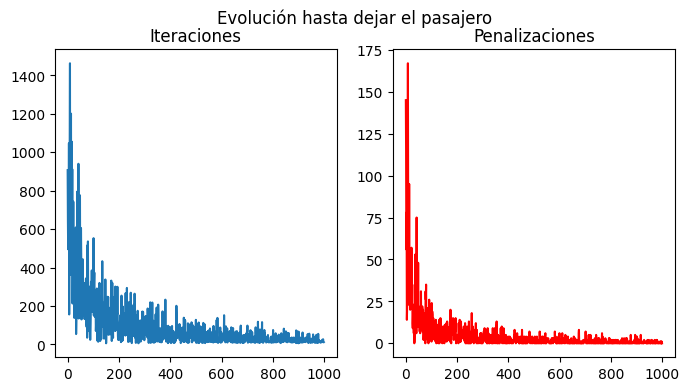

In [29]:
agente = AgenteRL(entorno, inicio="zero")
Evolucion(agente,1000,"all")

Se realizaron 10.8 en promedio.
con 0.28 penalizaciones en promedio.


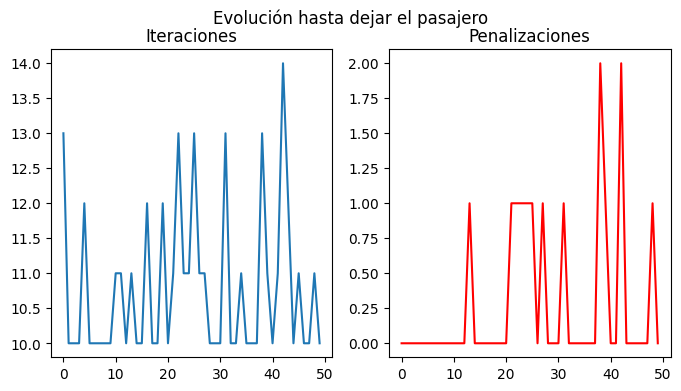

In [30]:
Evolucion(agente,50,semilla=6)

Podemos mejorar el agente para que se desempeñe bien usando cualquier semilla?

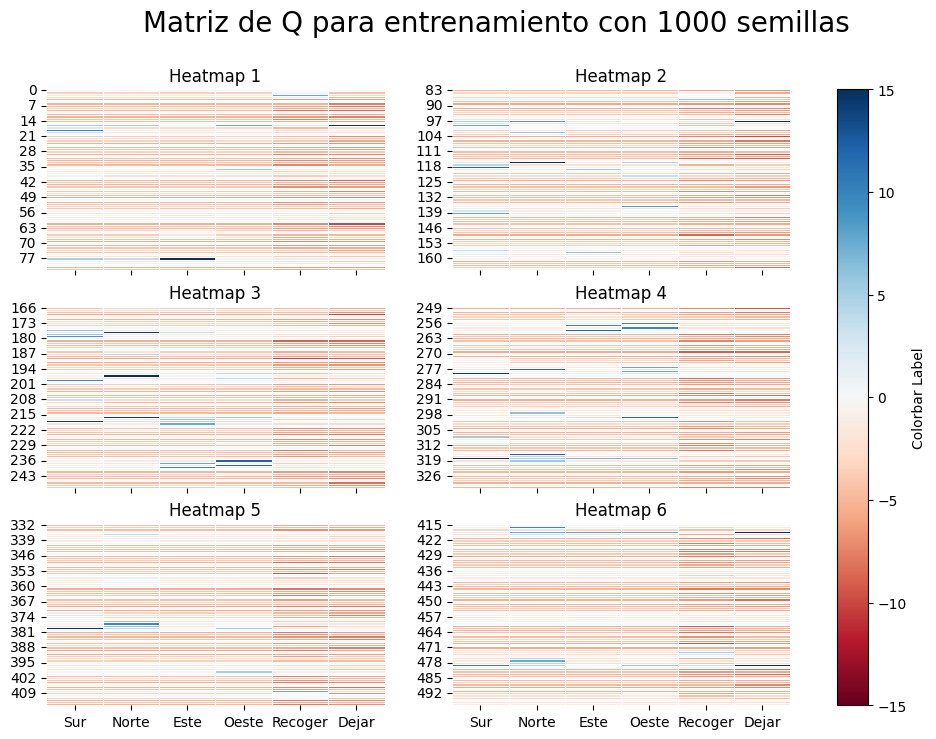

In [32]:
submatrices = split_matrix(agente.Q, 6)
grilla_plot(submatrices, 2 , 3, colormap = plt.cm.RdBu, titulo = "Matriz de Q para entrenamiento con 1000 semillas")

Vemos luego de entrenar con una diversidad más grande de semillas que la matriz aparece más poblada lo que nos demuestra que el agente tuvo posibilidad de recorrer una mayor cantidad de estados durante su entrenamiento. Vemos que aparecen claramente marcados 4 estados en los que el taxi puntúa como buena la acción de levantar, una por cada posible punto del mapa. Algo más tenue pero que de todas formas podemos observar es que en la columna de recoger se notan también 4 marcas. Y vemos que aparecen varios estados en los que el agente puntua alto tomar las decisiones de las direcciones.

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 49
Estado: 0
Accion: 5
Recompensa: 20
Se realizaron 29.2 en promedio.
con 0.8 penalizaciones en promedio.


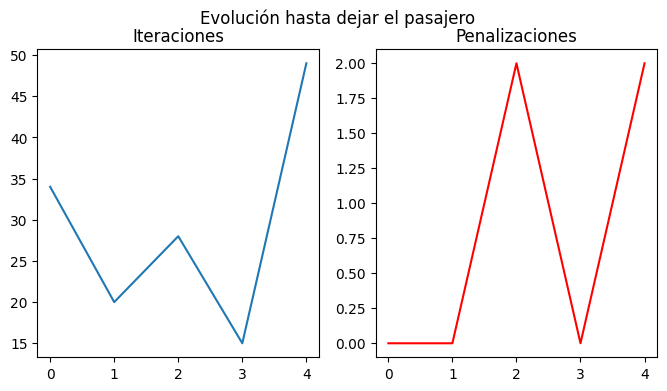

In [38]:
Evolucion(agente,5,semilla=15,reproducir = True)

--------------------------------------